In [1]:
from __future__ import print_function, division
import os
import os.path
import json
import numpy as np
import sys
import pickle
import glob
import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

path = "/Users/janelameski/Desktop/jane/Thesis/point_clouds/"

In [10]:
#list the files in path
file_list = []
for file in os.listdir(path):
    if file.endswith(".txt"):
        file_list.append(os.path.join(path, file))
        
file_list = sorted(file_list)
target_files = [a for a in file_list if "target" in a]
source_files = [a for a in file_list if "source" in a]

In [11]:
file = np.loadtxt(path+"0A0602_source.txt")
file2 = np.loadtxt(path+"0A0602_target.txt")

In [74]:
class PointCloudsDataset(Dataset):
    """Point clouds dataset."""

    def __init__(self, path, transform=None):
        """
        Args:
            path (string): Path to the pointclouds.
        """
        
        self.path = path
        self.file_list = []
        for file in os.listdir(path):
            if file.endswith(".txt"):
                file_list.append(os.path.join(path, file))
        self.target_files = [a for a in self.file_list if "target" in a]
        self.source_files = [a for a in self.file_list if "source" in a]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

(4098, 7)
(4098, 7)


<IPython.core.display.Javascript object>


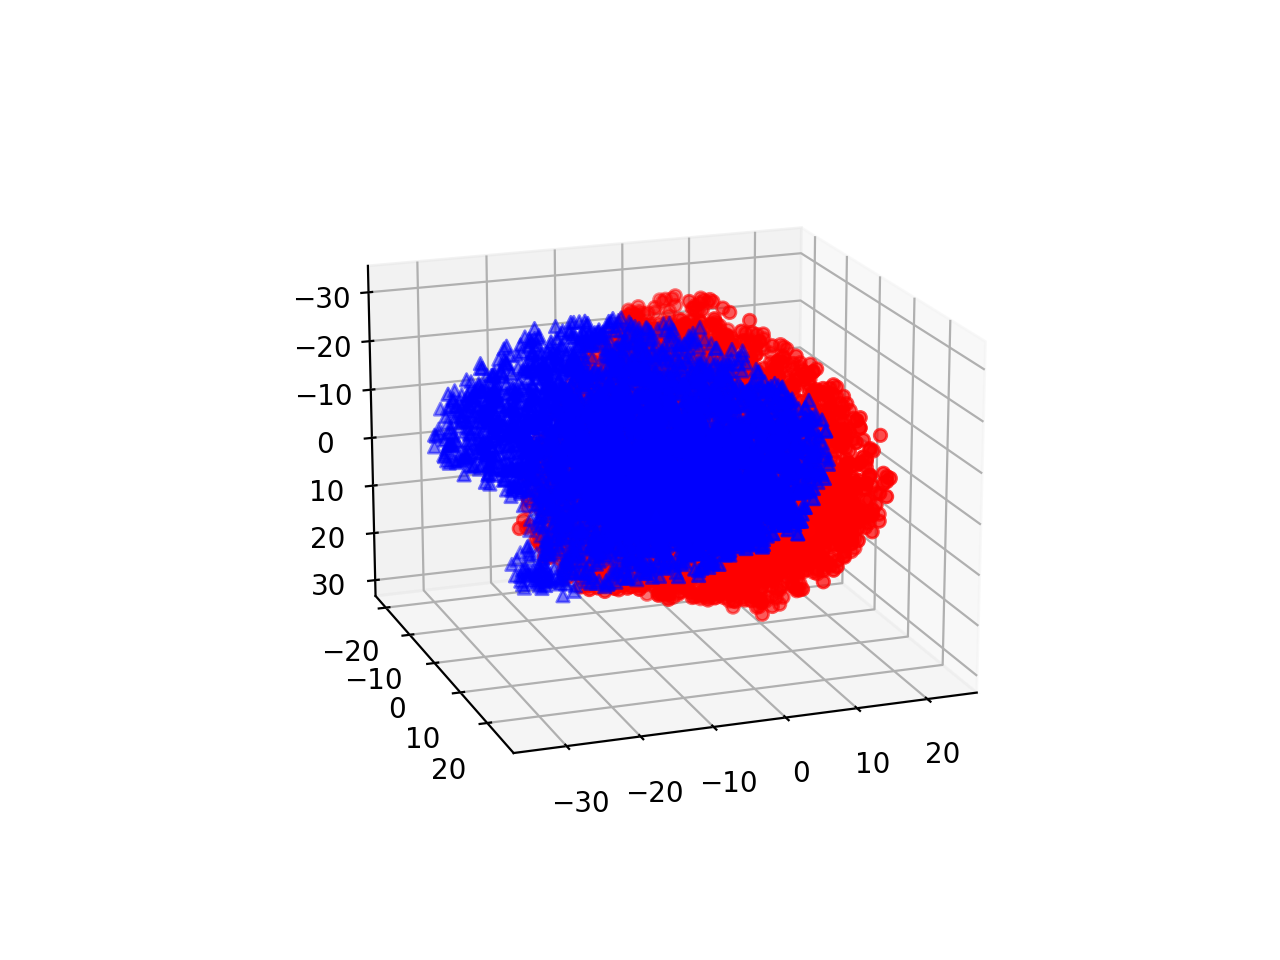

In [4]:
#loader
class DatasetLoader():
    def __init__(self, root=path, npoints=4096):
        self.npoints = npoints
        self.train = train
        self.root = root
        self.sourcepath = sorted(glob.glob(os.path.join(self.root, '*source.txt')))
        self.targetpath = sorted(glob.glob(os.path.join(self.root, '*target.txt')))
       
        self.cache = {}
        self.cache_size = 30000


    def __getitem__(self, index):
        if index in self.cache:
            source, target = self.cache[index]
        else:
            s = self.sourcepath[index]
            t = self.targetpath[index]
#             print(s, t)
            source = np.loadtxt(s)
            target = np.loadtxt(t)

            if len(self.cache) < self.cache_size:
                self.cache[index] = (source,target)


        n1 = source.shape[0]
        sample_idx1 = np.random.choice(n1, self.npoints, replace=False)
        n2 = target.shape[0]
        sample_idx2 = np.random.choice(n2, self.npoints, replace=False)

        source_ = np.copy(source[sample_idx1, :])
        target_ = np.copy(target[sample_idx2, :])

        return source_, target_

    def __len__(self):
        return len(self.sourcepath) + len(self.targetpath)



d = DatasetLoader()

for i in range(5):
    pc1, pc2, = d[i]
    print(pc1.shape)
    print(pc2.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc1[:,0], pc1[:,1], pc1[:,2], c='r', marker='o')
    ax.scatter(pc2[:,0], pc2[:,1], pc2[:,2], c='b', marker='^')
    break
  